In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

### Papers and literature

[Advances in Gaussian random field generation: a review](https://link.springer.com/content/pdf/10.1007/s10596-019-09867-y.pdf)

[Advice on covariance functions](https://www.cs.toronto.edu/~duvenaud/cookbook/)

### Build mesh - material points

In [2]:
def build_material_point_coordinates(dx, n_div_x, n_div_y):
    
    nodal_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0
    
    for i_y in range(n_div_y):      # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            nodal_coordinates[counter, 0] = coord_x
            nodal_coordinates[counter, 1] = coord_y
            counter += 1
            
    print("Number of nodes:", np.shape(nodal_coordinates)[0])
            
    return nodal_coordinates

Number of nodes: 2500


(-0.01225, 0.25725, -0.01225, 0.25725)

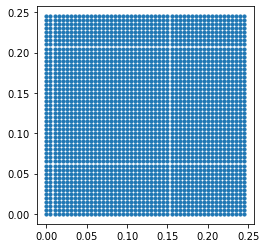

In [3]:
nodal_coords = build_material_point_coordinates(5e-3, 50, 50)
plt.scatter(nodal_coords[:, 0], nodal_coords[:, 1], s=10)
plt.axis('scaled') 

### Random field - parameters

In [4]:
mean_fc = 42.3           # Mean value of the random field (compressive strength MPa)
std_deviation = 5        # Standard deviation of the random field TODO: rename (this is an existing function)
threshold = 0.5          # Threshold value for the correlation function
correlation_length = 1   # Robin van der Have (2015) recommends that the correlation length is set to 1m

### Matrix decomposition method

In [5]:
def build_correlation_matrix(mesh, c1, lc):
    
    correlation_mat = np.zeros([len(mesh), len(mesh)])
    
    for i in range(len(mesh)):
        for j in range(i+1):
            correlation_mat[i, j] = c1 + (1 - c1) * np.exp(-np.linalg.norm(mesh[i, :] - mesh[j, :]) / lc)
            correlation_mat[j, i] = correlation_mat[i, j]
    
    return correlation_mat

In [6]:
def build_log_normal_distribution(std_dev, mean, correlation_mat):
    
    std_norm = np.sqrt(np.log(1 + std_dev / mean)**2)
    correlation_mat = (np.exp(correlation_mat * std_norm**2) - 1) / (np.exp(std_norm**2) - 1)
    plt.imshow(correlation_mat)
    
    return correlation_mat

In [7]:
def decompose_correlation_matrix(correlation_mat, mean, std_dev):
    
    eigenvalues, eigenvectors = np.linalg.eig(correlation_mat)
    L = eigenvectors * np.sqrt(np.absolute(eigenvalues))
    RV = np.random.uniform(low=0.0, high=1.0, size=[len(correlation_mat)])
    correlated_random_variables = mean + (np.matmul(L, RV) * std_dev)

    return correlated_random_variables


In [8]:
def build_correlated_random_variables(mesh, c1, lc, mean, std_dev):
    
    correlation_mat = build_correlation_matrix(mesh, c1, lc)
    correlation_mat = build_log_normal_distribution(std_dev, mean, correlation_mat)
    CRV = decompose_correlation_matrix(correlation_mat, mean, std_dev)
    
    return CRV

Time: 23.14117001


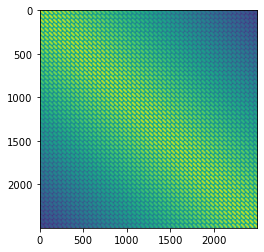

In [9]:
t0 = time.perf_counter()
crv = build_correlated_random_variables(nodal_coords, threshold, correlation_length, mean_fc, std_deviation)
t1 = time.perf_counter()
print("Time:", t1 - t0)

/Users/mark/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/mark/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


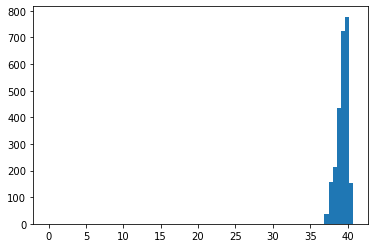

In [10]:
plt.hist(crv, 75, range=(0, np.max(crv)));

/Users/mark/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4193: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


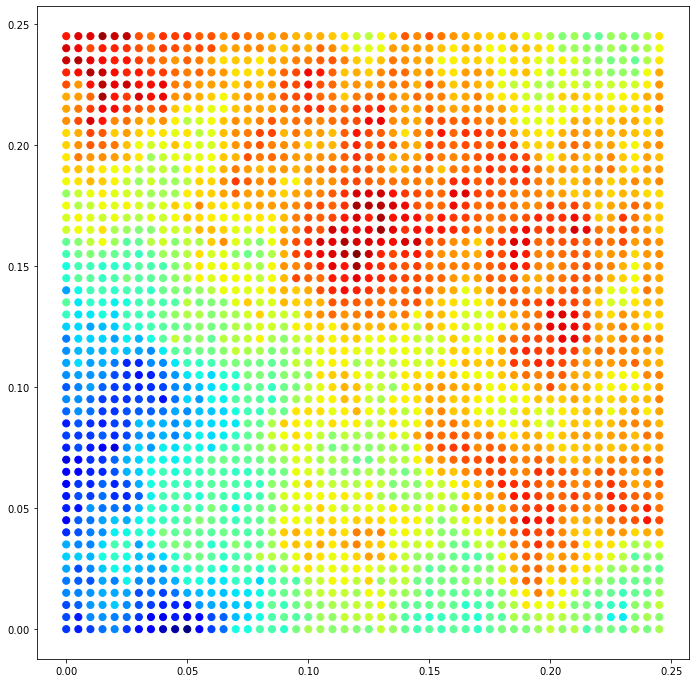

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(nodal_coords[:,0], nodal_coords[:,1], s=50, 
           c=crv, marker = 'o', cmap = cm.jet );
plt.axis('scaled'); 

### Karhunen-Loeve Expansion

In [12]:
k = 300  # return the k largest magnitude eigenvalues